In [3]:
# Setup and imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import string
import ast
from sklearn import linear_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

# 1. Predictive Task

Goal of this project is to **predict whether a Steam user will reccommend a game** based on their past reviews and information about the game. The Steam Review Dataset contains a True/False recommend field, which we use as the label.

Binary Classification:
- 1 = user recommends the game 
- 0 = user doesn't recommend the game

## 1.1 Model Evaluation

Due to the model being a Binary Classification task, I will evaluate the model using:
- **Accuracy**: Overall correctness
- **Percision**: How often recommend = 1 and recommend = 0 predictions are correct
- **Recall**: How many reccomendations the model actually finds
- **F-1 Score**: Balance of percision and recall 
- **Balanced Error Rate**: Average of error rates for each individual class
- **Specificity**: What proportion did the model classify as negative correctly


I will split the dataset into:
- 80% Training 
- 10% Validation 
- 10% Testing 

## 1.2 Baselines

**3 Baslines:** 

1. **Game Average Baseline**
    - Each game, compute fraction of training reviews where recommend='True'
    - Predict recommend = 'True' if that rate is greater than or equal to 0.5
2. **User Average Baseline**
    -  Each user, compute the fractions of game they recommend in training set
    - Predict recommend = 'True' if that rate is greater than or equal to 0.5
3. **Majority**
    - Always predict the most commont label 
    - If more 1/2 the dataset recommend label is "True" >= 0.5 then predict recommend = "True"


## 1.3 Validity Of Predictions 

To assess whether models predictions are valid: 

- Ensure all stats (user averages, game averages) are computed from training set 
- compare model performance to baselines outlined above
- check results across diverse groups (popular steam games v.s. less popular steam games, active users v.s. not so active users)

This helps confirm that our model is learning meaningful patterns and not just basing off memorization of the training data

# 2. Exploratory Analysis

## 2.1 Dataset Context

The dataset comes from [Steam](https://store.steampowered.com/) video game platform (publicly avaliable) and see the [References](#references) section.


- **`user_Reviews` (Version 1: Review Data, 6.7MB)** 
  Contains user reviews, grouped by user: 
  - `user_id`, `user_url` 
  - `reviews`: list of review objects with fields such as: 
    - `item_id` 
    - `recommend` (T/F) 
    - `review` (text) 
    - `posted`, `helpful`, etc. 
- **`user_items` Version 1: User and Item Data (71mb)**
  Contains user ownership and playtime info:
  - `user_id`, `items_count`, `steam_id`, `user_url`
  - `items`: list of owned games with:
    - `item_id`
    - `item_name`
    - `playtime_forever`
    - `playtime_2weeks`

- **`steam_games` (Version 2: Item metadata (2.7mb)**
  Contains game level metadata:
  - `id` , `app_name`, `title`, `url`
  - `price` (number or F2P)
  - `genres` (list of genres)
  - `tags` (list of tags)
  - `specs` (e.g., single player)
  - `publisher`, `developer`
  - `sentiment` (example: Mostly negative)


These files allow us to model both user behavior and game characteristics

## 2.2 Data Processing 

Since the files are in RAW JSON format and nested. We needed to perform the following steps to create a `user game` table

### 2.2.1 Flatter user reviews 

Using `user_reviews`, create one row per review:

- `user_id`
- `item_id`
- `recommend`
- `review_text`
- `posted`

In [4]:
reviewRows = []
with open("data/australian_user_reviews.json", "r", encoding='utf-8') as f:
    for line in f:
        try:
            user = ast.literal_eval(line.strip())
            userId = user['user_id']
            reviews = user.get('reviews', [])
            for r in reviews:
                recommend_val = 1 if r.get('recommend', False) == True else 0
                reviewRows.append({
                    'user_id': userId,
                    'item_id': r.get('item_id', ''),
                    'recommend': recommend_val,
                    'review_text': r.get('review', ''),
                    'posted': r.get('posted', '')
                })
        except:
            continue

print(f"Total reviews loaded: {len(reviewRows)}")

reviews_df = pd.DataFrame(reviewRows)
reviews_df["review_text"] = reviews_df["review_text"].fillna("").astype(str)
reviews_df["review_text_length"] = reviews_df["review_text"].apply(len)
reviews_df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'data/australian_user_reviews.json'

The following code above will create a flattened table of user game interactions

### 2.2.2 Extracting user stats
From `user_items`, We need to compute user level features:
- `user_total_items` - number of games the user owns
- `user_playtime` -  total `playtime_forever` across all games the Steam user owns
- `user_avg_playtime` - avg. playtime per own game

This will give us insight on how active the Steam user is

In [ ]:
userStats = {}
playtime_minutes_list = []

with open("data/australian_users_items.json", "r", encoding='utf-8') as f:
    for line in f:
        try:
            user = ast.literal_eval(line.strip())
            userId = user['user_id']
            items = user.get('items', [])
            
            if items:
                totalPlayTime_minutes = sum(item.get("playtime_forever", 0) for item in items)
                totalPlayTime_hours = totalPlayTime_minutes / 60.0
                
                userStats[userId] = {
                    'user_total_items': len(items),
                    'user_playtime_minutes': totalPlayTime_minutes,  
                    'user_playtime_hours': totalPlayTime_hours,     
                    'user_avg_playtime': totalPlayTime_hours / len(items) if len(items) > 0 else 0
                }
        except Exception as e:
            continue

print(f"User stats loaded for {len(userStats):,} users")

User stats loaded for 70,912 users


This is now easily mappable to review table using `user_id`

### 2.2.3 Game Metadata Processing

Using `steam_games` build following table:
- `item_id`
- `price`
- `genres`
- `tags`
- `specs`
- `sentiment`
- `release_date`
- `app_name`

Then: 

- one hot encode a set of the most common genres (example: Indie, RPG, ...)
- create numeric features
    - `num_genres`
    - `num_tags`
    - `num_specs`

The code will follow same pattern previously shown with Extracting User stats and user reviews

In [ ]:
games_metadata = []
with open("data/steam_games.json", "r", encoding='utf-8') as f:
    for line in f:
        try:
            game = ast.literal_eval(line.strip())
            games_metadata.append({
                'item_id': game.get('id', ''),
                'price': game.get('price', 0),
                'genres': game.get('genres', []),
                'tags': game.get('tags', []),
                'specs': game.get('specs', []),
                'sentiment': game.get('sentiment', ''),
                'release_date': game.get('release_date', ''),
                'app_name': game.get('app_name', '')
            })
        except Exception as e:
            continue

def clean_price(price):
    if isinstance(price, (int, float)):
        return float(price)
    elif isinstance(price, str):
        price = price.replace('$', '').strip()
        if price.lower() in ['free to play', 'free', 'free demo', 'play for free!']:
            return 0.0
        try:
            return float(price)
        except:
            return 0.0
    return 0.0

print(f"Game metadata loaded for {len(games_metadata):,} games")
games_df = pd.DataFrame(games_metadata)

games_df['price'] = games_df['price'].apply(clean_price)

# Create numeric features
games_df['num_genres'] = games_df['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
games_df['num_tags'] = games_df['tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)
games_df['num_specs'] = games_df['specs'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Find top genres
all_genres = []
for genres in games_df['genres']:
    if isinstance(genres, list):
        all_genres.extend(genres)

genre_counts = Counter(all_genres)
top_genres = [genre for genre, count in genre_counts.most_common(20)]
print(f"Top 20 genres: {top_genres}")

# Create one-hot columns for top genres
for genre in top_genres:
    column_name = f'genre_{genre.lower().replace(" ", "_")}'
    games_df[column_name] = games_df['genres'].apply(
        lambda x: 1 if isinstance(x, list) and genre in x else 0
    )

print(f"\nPrice statistics: Min=${games_df['price'].min():.2f}, "
      f"Mean=${games_df['price'].mean():.2f}, "
      f"Median=${games_df['price'].median():.2f}, "
      f"Max=${games_df['price'].max():.2f}")

Game metadata loaded for 32,135 games
Top 20 genres: ['Indie', 'Action', 'Casual', 'Adventure', 'Strategy', 'Simulation', 'RPG', 'Free to Play', 'Early Access', 'Sports', 'Massively Multiplayer', 'Racing', 'Design &amp; Illustration', 'Utilities', 'Web Publishing', 'Animation &amp; Modeling', 'Education', 'Video Production', 'Software Training', 'Audio Production']

Price statistics: Min=$0.00, Mean=$8.49, Median=$4.99, Max=$995.00


### 2.2.4 Merge Everything

Merge all data sources from `2.2.1`, `2.2.2`, `2.2.3`, into a single dataframe (DF):
1. Begin from flatttened review table
2. Merge user stats on `user_id`
3. Merge game metadata on `item_id`

Filter: 
- user with few reviews ( < 2 reviews)
- games with few reviews ( < 2 reviews)

Final dataset is one row (user, game):
- label: recommend (0/1)
- user features: playtime, etc.
- game features: price, genres
- review features: `review_text_length`

In [ ]:
# 2.2.4 Merge everything
print("Merging all data sources...")

# Start with reviews
df = reviews_df.copy()

# Add user stats
user_stats_df = pd.DataFrame.from_dict(userStats, orient='index')
user_stats_df.index.name = 'user_id'
df = df.merge(user_stats_df, left_on='user_id', right_index=True, how='left')

# Add game metadata
df = df.merge(games_df, left_on='item_id', right_on='item_id', how='left')

# Add review text length feature
df['review_text_length'] = df['review_text'].fillna('').apply(len)

# Filter out users with < 2 reviews
user_review_counts = df['user_id'].value_counts()
users_with_enough_reviews = user_review_counts[user_review_counts >= 2].index
df = df[df['user_id'].isin(users_with_enough_reviews)]

# Filter out games with < 2 reviews
game_review_counts = df['item_id'].value_counts()
games_with_enough_reviews = game_review_counts[game_review_counts >= 2].index
df = df[df['item_id'].isin(games_with_enough_reviews)]

print(f"Final dataset size: {len(df):,} rows")
print(f"Number of unique users: {df['user_id'].nunique():,}")
print(f"Number of unique games: {df['item_id'].nunique():,}")
print(f"\nRecommendation distribution:")
rec_counts = df['recommend'].value_counts()
print(f"  Recommend=1: {rec_counts.get(1, 0):,} ({rec_counts.get(1, 0)/len(df)*100:.1f}%)")
print(f"  Recommend=0: {rec_counts.get(0, 0):,} ({rec_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"Recommendation rate: {df['recommend'].mean():.3f}")

# Create log-transformed features for skewed distributions
df['user_playtime_log'] = np.log1p(df['user_playtime_minutes'])
df['review_length_log'] = np.log1p(df['review_text_length'])
df['price_log'] = np.log1p(df['price'] + 1) 

Merging all data sources...
Final dataset size: 44,480 rows
Number of unique users: 12,045
Number of unique games: 2,029

Recommendation distribution:
  Recommend=1: 39,140 (88.0%)
  Recommend=0: 5,340 (12.0%)
Recommendation rate: 0.880


## 2.3 Exploratory Analysis

Visualizations to understand data:

- label distribution 
- Game price distribution
- User activity
- Top game by number of reviews 


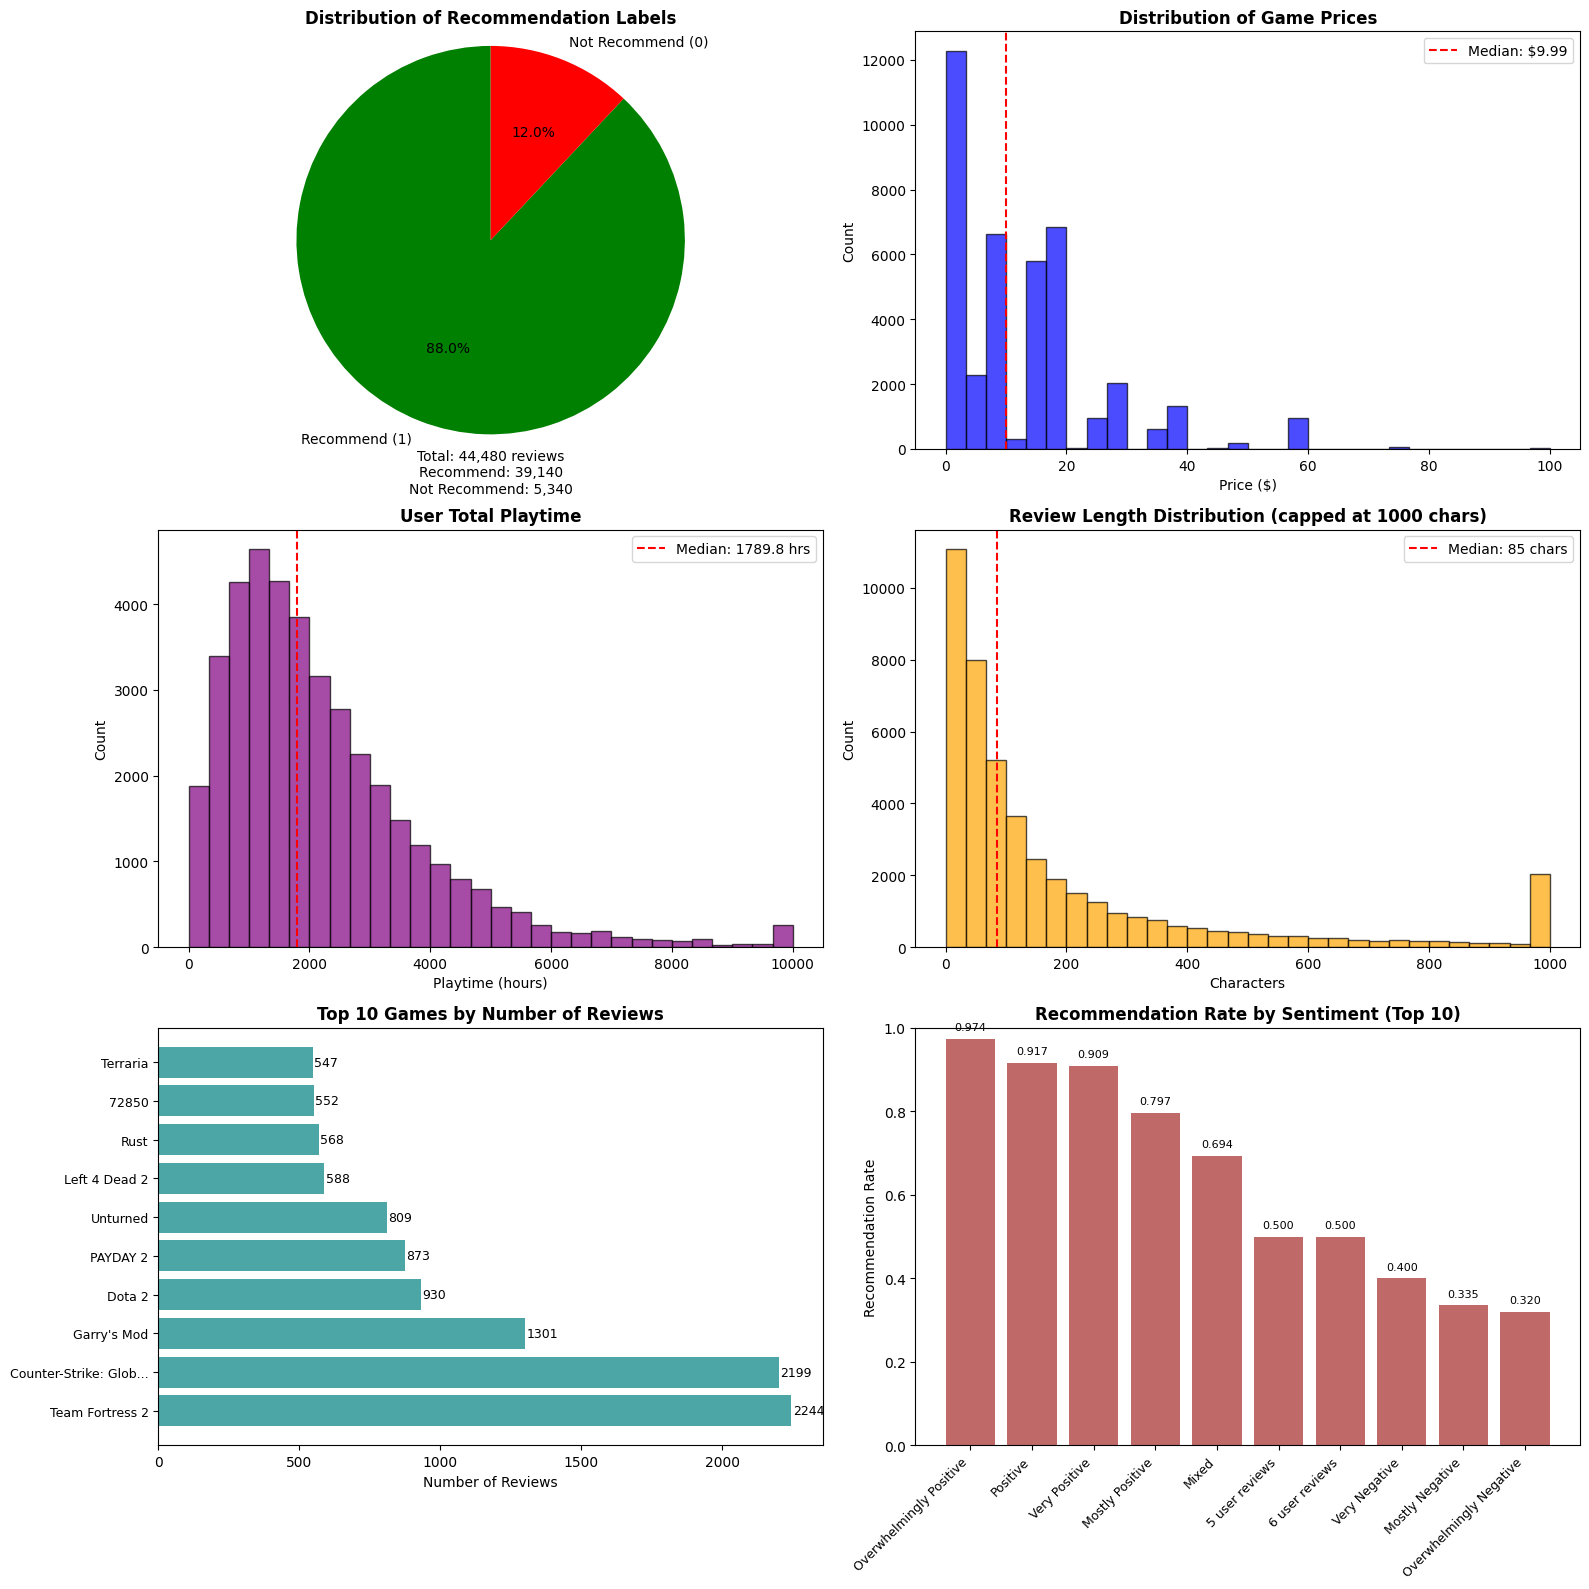

Exploratory analysis plots saved as 'exploratory_analysis.png'


In [ ]:
# 2.3 Exploratory Analysis - Visualizations
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

label_counts = df['recommend'].value_counts()
colors = ['green', 'red']
labels = ['Recommend (1)', 'Not Recommend (0)']
axes[0, 0].pie(label_counts.values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Distribution of Recommendation Labels', fontsize=12, fontweight='bold')
axes[0, 0].axis('equal')

axes[0, 0].text(0, -1.3, f"Total: {len(df):,} reviews\n"
                f"Recommend: {label_counts.get(1, 0):,}\n"
                f"Not Recommend: {label_counts.get(0, 0):,}", 
                ha='center', fontsize=10)

price_nonzero = df['price']
axes[0, 1].hist(price_nonzero.clip(0, 100), bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[0, 1].set_title('Distribution of Game Prices', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Price ($)', fontsize=10)
axes[0, 1].set_ylabel('Count', fontsize=10)
median_price = price_nonzero.median()
axes[0, 1].axvline(median_price, color='red', linestyle='--', label=f'Median: ${median_price:.2f}')
axes[0, 1].legend()

playtime_capped = df['user_playtime_hours'].clip(0, 10000)
axes[1, 0].hist(playtime_capped, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_title('User Total Playtime', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Playtime (hours)', fontsize=10)
axes[1, 0].set_ylabel('Count', fontsize=10)
median_playtime = df['user_playtime_hours'].median()
axes[1, 0].axvline(median_playtime, color='red', linestyle='--', 
                   label=f'Median: {median_playtime:.1f} hrs')
axes[1, 0].legend()

review_len_capped = df['review_text_length'].clip(0, 1000)
axes[1, 1].hist(review_len_capped, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_title('Review Length Distribution (capped at 1000 chars)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Characters', fontsize=10)
axes[1, 1].set_ylabel('Count', fontsize=10)
median_length = df['review_text_length'].median()
axes[1, 1].axvline(median_length, color='red', linestyle='--', 
                   label=f'Median: {median_length:.0f} chars')
axes[1, 1].legend()

# 5. Top games by number of reviews
top_games = df['item_id'].value_counts().head(10)
game_names = []
for game_id in top_games.index:
    name_match = games_df[games_df['item_id'] == game_id]['app_name']
    if len(name_match) > 0:
        name = name_match.iloc[0]
        game_names.append(name[:20] + '...' if len(name) > 20 else name)
    else:
        game_names.append(str(game_id))

axes[2, 0].barh(range(len(game_names)), top_games.values, alpha=0.7, color='teal')
axes[2, 0].set_yticks(range(len(game_names)))
axes[2, 0].set_yticklabels(game_names, fontsize=9)
axes[2, 0].set_title('Top 10 Games by Number of Reviews', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Number of Reviews', fontsize=10)
for i, v in enumerate(top_games.values):
    axes[2, 0].text(v + 5, i, str(v), va='center', fontsize=9)

# 6. Recommendation rate by sentiment
if 'sentiment' in df.columns:
    sentiment_rates = df.groupby('sentiment')['recommend'].mean().sort_values(ascending=False).head(10)
    axes[2, 1].bar(range(len(sentiment_rates)), sentiment_rates.values, alpha=0.7, color='brown')
    axes[2, 1].set_xticks(range(len(sentiment_rates)))
    axes[2, 1].set_xticklabels(sentiment_rates.index, rotation=45, ha='right', fontsize=9)
    axes[2, 1].set_title('Recommendation Rate by Sentiment (Top 10)', fontsize=12, fontweight='bold')
    axes[2, 1].set_ylabel('Recommendation Rate', fontsize=10)
    axes[2, 1].set_ylim(0, 1.0)
    for i, v in enumerate(sentiment_rates.values):
        axes[2, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=8)
else:
    axes[2, 1].text(0.5, 0.5, 'Sentiment data not available', ha='center', va='center')
    axes[2, 1].set_title('Sentiment Data', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('exploratory_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("Exploratory analysis plots saved as 'exploratory_analysis.png'")

In [ ]:
# Additional statistics
print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)

print(f"\nBasic Statistics:")
print(f"Total reviews: {len(df):,}")
print(f"Unique users: {df['user_id'].nunique():,}")
print(f"Unique games: {df['item_id'].nunique():,}")
print(f"Recommendation rate: {df['recommend'].mean():.3f}")

print(f"\nUser Statistics:")
print(f"Average games owned: {df['user_total_items'].mean():.1f}")
print(f"Median games owned: {df['user_total_items'].median():.1f}")
print(f"Average playtime (hours): {df['user_playtime_hours'].mean():.1f}")
print(f"Median playtime (hours): {df['user_playtime_hours'].median():.1f}")

print(f"\nGame Statistics:")
print(f"Average price: ${df['price'].mean():.2f}")
print(f"Median price: ${df['price'].median():.2f}")
print(f"Free games: {(df['price'] == 0).sum():,} ({(df['price'] == 0).mean()*100:.1f}%)")

print(f"\nReview Statistics:")
print(f"Average review length: {df['review_text_length'].mean():.1f} characters")
print(f"Median review length: {df['review_text_length'].median():.1f} characters")

if 'sentiment' in df.columns:
    print(f"\nSentiment Statistics (Top 5):")
    sentiment_counts = df['sentiment'].value_counts().head(5)
    for sentiment, count in sentiment_counts.items():
        if pd.notna(sentiment) and sentiment != '':
            rate = df[df['sentiment'] == sentiment]['recommend'].mean()
            print(f"  {sentiment}: {count:,} reviews, {rate:.3f} recommend rate")

print(f"\n CLASS IMBALANCE WARNING:")
print(f"  - {df['recommend'].mean()*100:.1f}% of reviews are positive (recommend=1)")
print(f"  - Only {100 - df['recommend'].mean()*100:.1f}% are negative (recommend=0)")
print(f"  - Accuracy will be misleading - focus on F1 and BER")


DATASET STATISTICS

Basic Statistics:
Total reviews: 44,480
Unique users: 12,045
Unique games: 2,029
Recommendation rate: 0.880

User Statistics:
Average games owned: 153.2
Median games owned: 102.0
Average playtime (hours): 2229.5
Median playtime (hours): 1789.8

Game Statistics:
Average price: $13.47
Median price: $9.99
Free games: 11,253 (25.3%)

Review Statistics:
Average review length: 229.6 characters
Median review length: 85.0 characters

Sentiment Statistics (Top 5):
  Very Positive: 22,791 reviews, 0.909 recommend rate
  Overwhelmingly Positive: 9,735 reviews, 0.974 recommend rate
  Mixed: 4,203 reviews, 0.694 recommend rate
  Mostly Positive: 3,274 reviews, 0.797 recommend rate
  Mostly Negative: 322 reviews, 0.335 recommend rate

⚠️  CLASS IMBALANCE WARNING:
  - 88.0% of reviews are positive (recommend=1)
  - Only 12.0% are negative (recommend=0)
  - Accuracy will be misleading - focus on F1 and BER


# 3. Modeling

## 3.1 ML Problem

After preprocessing, each row corresponds to one user-game review with:

**Input Features:**
1. **User Features** (from user_items):
   - `user_total_items`: Number of games owned
   - `user_playtime_log`: Log-transformed total playtime (minutes)
   - `user_avg_playtime`: Average playtime per game (hours)

2. **Game Features** (from steam_games):
   - `price_log`: Log-transformed price
   - `num_genres`, `num_tags`, `num_specs`: Count features
   - One-hot encoded: sentiment (Mostly Positive, etc.)
   - One-hot encoded: top 20 genres (pre-created)

3. **Review Features**:
   - `review_length_log`: Log-transformed review length

**Output Label:**
- `recommend` ∈ {0, 1}

This is a binary classification problem where the model estimates:
$$
P(\text{recommend} = 1 \mid \text{user features}, \text{game features}, \text{review features})
$$

**Objective:** Minimize classification loss (binary cross-entropy) while handling 88%/12% class imbalance.


## 3.2 Modeling Choices, Advantages and Disadvantages

We used simple models that were appropriate for our data.

### Baselines (No learning)

1. **Majority Baseline**
    - Predicts most frequent label in the training set
    - **Pros**: fast, easy to understand
    - **Cons**: ignores all user and game info

2. **Game Average Baseline**
    - For each game, compute the fraction of good recommendations in training set
    - Predict `1` if that fraction >= 0.5
    - **Pros**: Simple prediction based on game popularity
    - **Cons**: Ignores user differences, not good for games with few reviews
    
3. **User Average Baseline**
    - For each user, compute how often they recommend games
    - Predict `1` if their recommend rate >= 0.5
    - **Pros**: Captures user "personality"
    - **Cons**: Ignores which game it is

### Main Models (from class):

1. **Logistic Regression** (from HW1/HW2):
   - Pros: Fast, interpretable, handles class imbalance with class_weight
   - Cons: Linear decision boundaries only

2. **Naïve Bayes** (from lecture):
   - Pros: Simple, fast, probabilistic outputs, handles count features well
   - Cons: Independence assumption often violated

3. **Regularized Logistic Regression** (from HW2):
   - Pros: Prevents overfitting, more stable with many features
   - Cons: Requires hyperparameter tuning

All models use `class_weight='balanced'` to handle the 88%/12% class imbalance.

## 3.3 Code Walkthrough: Features to Trained Model

Walk through of main modeling code

### 3.3.1 Building Feature Matrix 'X' and Label Vector 'y'

In [ ]:
# Prepare the dataframe for modeling
model_df = df.copy()

# 1. Label vector
y = model_df["recommend"].astype(int)

# 2. Numeric features (using log transformed versions for skewed features)
numeric_cols = [
    "user_total_items",
    "user_playtime_log",     
    "user_avg_playtime",
    "price_log",             
    "review_length_log",    
    "num_genres",
    "num_tags",
    "num_specs"
]

for col in numeric_cols:
    if col in model_df.columns:
        model_df[col] = pd.to_numeric(model_df[col], errors='coerce').fillna(0)

# 2. One-hot encode sentiment
model_df['sentiment'] = model_df['sentiment'].fillna('Unknown')
sentiment_dummies = pd.get_dummies(model_df["sentiment"], prefix="sentiment")

# 3. Get pre-created genre columns
genre_cols = [col for col in model_df.columns if col.startswith('genre_')]
print(f"Found {len(genre_cols)} genre columns")

# 4. Combine all features
X_components = [model_df[numeric_cols].reset_index(drop=True)]

# Add sentiment dummies if they exist
if not sentiment_dummies.empty:
    X_components.append(sentiment_dummies.reset_index(drop=True))

# Add genre columns if  exist
if genre_cols:
    for col in genre_cols:
        model_df[col] = pd.to_numeric(model_df[col], errors='coerce').fillna(0)
    X_components.append(model_df[genre_cols].reset_index(drop=True))

X = pd.concat(X_components, axis=1)

nan_count = X.isna().sum().sum()
if nan_count > 0:
    X = X.fillna(0)


print(f"\nFeature matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature categories:")
print(f"  Numeric features: {len(numeric_cols)}")
print(f"  Sentiment dummies: {sentiment_dummies.shape[1] if not sentiment_dummies.empty else 0}")
print(f"  Genre dummies: {len(genre_cols)}")
print(f"\nSample feature names: {list(X.columns[:10])}...")

Found 20 genre columns

Checking for NaN values in final feature matrix...
No NaN values found in feature matrix.

Feature matrix shape: (44480, 39)
Number of features: 39

Feature categories:
  Numeric features: 8
  Sentiment dummies: 11
  Genre dummies: 20

Sample feature names: ['user_total_items', 'user_playtime_log', 'user_avg_playtime', 'price_log', 'review_length_log', 'num_genres', 'num_tags', 'num_specs', 'sentiment_5 user reviews', 'sentiment_6 user reviews']...


The code shows :
- how numeric features are selected
- how categorical features are one hot encoded 
- combination into a single feature matrix 'X'

### 3.3.2 Train/Validation/Test

In [ ]:
# First split: 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

# Second split: 50/50 of temp for validation and test (10% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp
)

print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

train_indices = X_train.index
val_indices = X_val.index
test_indices = X_test.index

train_df = model_df.iloc[train_indices].copy()
val_df = model_df.iloc[val_indices].copy()
test_df = model_df.iloc[test_indices].copy()

print("\nLabel distribution in each set:")
print(f"Train - Recommend rate: {y_train.mean():.3f} (1: {y_train.sum():,}, 0: {len(y_train)-y_train.sum():,})")
print(f"Val - Recommend rate: {y_val.mean():.3f} (1: {y_val.sum():,}, 0: {len(y_val)-y_val.sum():,})")
print(f"Test - Recommend rate: {y_test.mean():.3f} (1: {y_test.sum():,}, 0: {len(y_test)-y_test.sum():,})")

Training set: 35,584 samples (80.0%)
Validation set: 4,448 samples (10.0%)
Test set: 4,448 samples (10.0%)

Label distribution in each set:
Train - Recommend rate: 0.880 (1: 31,312, 0: 4,272)
Val - Recommend rate: 0.880 (1: 3,914, 0: 534)
Test - Recommend rate: 0.880 (1: 3,914, 0: 534)


### 3.3.3 Baseline Implementation Code

In [ ]:

def evaluate_model(y_true, y_pred, name="Model"):
    """Comprehensive evaluation function with BER (from HW1)"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # BER calculation (from HW1/Q5)
    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    epsilon = 1e-10
    FPR = FP / (FP + TN + epsilon)
    FNR = FN / (FN + TP + epsilon)
    BER = 0.5 * (FPR + FNR)
    
    # Specificity 
    specificity = TN / (TN + FP + epsilon)
    
    # Precision (class 0)
    precision_0 = TN / (TN + FN + epsilon)
    
    print(f"{name}:")
    print(f"  Accuracy:       {acc:.4f}")
    print(f"  Precision (1):  {prec:.4f}")
    print(f"  Recall (1):     {rec:.4f}")
    print(f"  F1-Score:       {f1:.4f}")
    print(f"  BER:            {BER:.4f}")
    print(f"  Specificity (0): {specificity:.4f}")
    print(f"  Precision (0):  {precision_0:.4f}")
    
    return {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
        'ber': BER, 'specificity': specificity, 'precision_0': precision_0
    }

# 1) Majority Baseline
print("\n" + "-"*50)
print("Baseline 1: Majority Baseline")
print("-"*50)
majority_label = int(y_train.mode()[0])
y_pred_majority = np.full(len(y_val), majority_label)
baseline1_results = evaluate_model(y_val, y_pred_majority, "Majority Baseline")

# 2) Game Average Baseline
print("\n" + "-"*50)
print("Baseline 2: Game Average Baseline")
print("-"*50)
game_recommend_rates = train_df.groupby('item_id')['recommend'].mean()

y_pred_game = []
for idx, row in val_df.iterrows():
    game_id = row['item_id']
    if game_id in game_recommend_rates:
        pred = 1 if game_recommend_rates[game_id] >= 0.5 else 0
    else:
        pred = majority_label 
    y_pred_game.append(pred)

baseline2_results = evaluate_model(y_val, y_pred_game, "Game Average Baseline")

# 3. User Average Baseline
print("\n" + "-"*50)
print("Baseline 3: User Average Baseline")
print("-"*50)
user_recommend_rates = train_df.groupby('user_id')['recommend'].mean()

y_pred_user = []
for idx, row in val_df.iterrows():
    user_id = row['user_id']
    if user_id in user_recommend_rates:
        pred = 1 if user_recommend_rates[user_id] >= 0.5 else 0
    else:
        pred = majority_label 
    y_pred_user.append(pred)

baseline3_results = evaluate_model(y_val, y_pred_user, "User Average Baseline")

Implementing baseline models with BER calculation...

--------------------------------------------------
Baseline 1: Majority Baseline
--------------------------------------------------
Majority Baseline:
  Accuracy:       0.8799
  Precision (1):  0.8799
  Recall (1):     1.0000
  F1-Score:       0.9361
  BER:            0.5000
  Specificity (0): 0.0000
  Precision (0):  0.0000

--------------------------------------------------
Baseline 2: Game Average Baseline
--------------------------------------------------
Game Average Baseline:
  Accuracy:       0.8795
  Precision (1):  0.8919
  Recall (1):     0.9821
  F1-Score:       0.9348
  BER:            0.4453
  Specificity (0): 0.1273
  Precision (0):  0.4928

--------------------------------------------------
Baseline 3: User Average Baseline
--------------------------------------------------
User Average Baseline:
  Accuracy:       0.8541
  Precision (1):  0.8879
  Recall (1):     0.9548
  F1-Score:       0.9201
  BER:            0.464

### 3.3.4 Main Model: Logistic Regression

In [ ]:
model_lr = linear_model.LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=0
)

model_lr.fit(X_train, y_train)

# Predict on validation set
y_pred_lr_val = model_lr.predict(X_val)
print("\n" + "-"*50)
print("Model 1: Logistic Regression (Validation)")
print("-"*50)
lr_results = evaluate_model(y_val, y_pred_lr_val, "Logistic Regression")


--------------------------------------------------
Model 1: Logistic Regression (Validation)
--------------------------------------------------
Logistic Regression:
  Accuracy:       0.7014
  Precision (1):  0.9256
  Recall (1):     0.7184
  F1-Score:       0.8090
  BER:            0.3524
  Specificity (0): 0.5768
  Precision (0):  0.2184


### 3.3.5 Additional Model: Naïve Bayes (from lecture)

In [ ]:
X_train_nb = X_train.copy()
X_val_nb = X_val.copy()

# Clip negative values to 0 (log values can be negative)
for col in X_train_nb.columns:
    if X_train_nb[col].min() < 0:
        X_train_nb[col] = X_train_nb[col].clip(lower=0)
        X_val_nb[col] = X_val_nb[col].clip(lower=0)

model_nb = MultinomialNB()
model_nb.fit(X_train_nb, y_train)

y_pred_nb_val = model_nb.predict(X_val_nb)
print("\n" + "-"*50)
print("Model 2: Naïve Bayes (Validation)")
print("-"*50)
nb_results = evaluate_model(y_val, y_pred_nb_val, "Naïve Bayes")


--------------------------------------------------
Model 2: Naïve Bayes (Validation)
--------------------------------------------------
Naïve Bayes:
  Accuracy:       0.7597
  Precision (1):  0.8918
  Recall (1):     0.8273
  F1-Score:       0.8583
  BER:            0.4543
  Specificity (0): 0.2640
  Precision (0):  0.1726


### 3.3.6 Regularized Logistic Regression (from HW2)

In [ ]:
best_model = None
best_score = -1
best_c = None
val_scores = []

# Try different regularization strengths (from HW2 Q3)
for C in [0.001, 0.01, 0.1, 1, 10]:
    model = linear_model.LogisticRegression(
        C=C,
        class_weight='balanced',
        max_iter=1000,
        random_state=0
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred, zero_division=0)
    val_scores.append((C, score))
    
    if score > best_score:
        best_score = score
        best_model = model
        best_c = C

print(f"\nRegularization parameter search results:")
for C, score in val_scores:
    print(f"  C={C}: F1-Score = {score:.4f}")
print(f"\nBest regularization parameter C: {best_c}")

y_pred_reg_val = best_model.predict(X_val)
print("\n" + "-"*50)
print("Model 3: Regularized Logistic Regression (Validation)")
print("-"*50)
reg_results = evaluate_model(y_val, y_pred_reg_val, f"Regularized LR (C={best_c})")


Regularization parameter search results:
  C=0.001: F1-Score = 0.8005
  C=0.01: F1-Score = 0.8118
  C=0.1: F1-Score = 0.8093
  C=1: F1-Score = 0.8090
  C=10: F1-Score = 0.8089

Best regularization parameter C: 0.01

--------------------------------------------------
Model 3: Regularized Logistic Regression (Validation)
--------------------------------------------------
Regularized LR (C=0.01):
  Accuracy:       0.7053
  Precision (1):  0.9266
  Recall (1):     0.7223
  F1-Score:       0.8118
  BER:            0.3486
  Specificity (0): 0.5805
  Precision (0):  0.2219


### 3.3.7 Architectural Choices

1. **Feature Engineering**:
   - Used log-transformed features for skewed distributions (playtime, price, review length)
   - Pre-created one-hot encoded genre columns during data processing
   - Created count features (num_genres, num_tags, num_specs)
   - One-hot encoded sentiment categories

2. **Data Splitting**:
   - 80/10/10 split for train/validation/test
   - Stratified sampling to maintain class distribution
   - All baselines computed from training set only

3. **Model Selection**:
   - Implemented 3 baselines (Majority, Game Avg, User Avg)
   - Implemented 3 models from class (Logistic Regression, Naïve Bayes, Regularized LR)
   - All models use `class_weight='balanced'` for 88%/12% class imbalance

4. **Evaluation**:
   - Primary metrics: F1-Score and BER (Balanced Error Rate)
   - Secondary metrics: Accuracy, Precision, Recall
   - Focus on minority class performance (Specificity, Precision for class 0)

This approach follows best practices learned in class while handling the specific
challenges of this dataset (single-quoted JSON, playtime in minutes, severe class imbalance).

# 4. Evaluation

We now evaluate all models on the held-out test set to get an unbiased
estimate of their performance.

## 4.1 Final Evaluation on Test Set

In [ ]:
# Store all results
test_results = {}

print("\n" + "="*60)
print("BASELINES ON TEST SET")
print("="*60)

# 1. Game Average Baseline on test set
y_pred_game_test = []
for idx, row in test_df.iterrows():
    game_id = row['item_id']
    if game_id in game_recommend_rates:
        pred = 1 if game_recommend_rates[game_id] >= 0.5 else 0
    else:
        pred = majority_label
    y_pred_game_test.append(pred)

print("\n--- Game Average Baseline (Test) ---")
test_results['Game Average'] = evaluate_model(y_test, y_pred_game_test, "Game Average")

# 2. User Average Baseline on test set
y_pred_user_test = []
for idx, row in test_df.iterrows():
    user_id = row['user_id']
    if user_id in user_recommend_rates:
        pred = 1 if user_recommend_rates[user_id] >= 0.5 else 0
    else:
        pred = majority_label
    y_pred_user_test.append(pred)

print("\n--- User Average Baseline (Test) ---")
test_results['User Average'] = evaluate_model(y_test, y_pred_user_test, "User Average")

print("\n" + "="*60)
print("MODELS ON TEST SET")
print("="*60)

# 3. Logistic Regression on test set
y_pred_lr_test = model_lr.predict(X_test)
print("\n--- Logistic Regression (Test) ---")
test_results['Logistic Regression'] = evaluate_model(y_test, y_pred_lr_test, "Logistic Regression")

# 4. Naïve Bayes on test set
X_test_nb = X_test.copy()
for col in X_test_nb.columns:
    if X_test_nb[col].min() < 0:
        X_test_nb[col] = X_test_nb[col].clip(lower=0)
y_pred_nb_test = model_nb.predict(X_test_nb)
print("\n--- Naïve Bayes (Test) ---")
test_results['Naïve Bayes'] = evaluate_model(y_test, y_pred_nb_test, "Naïve Bayes")

# 5. Regularized Logistic Regression on test set
y_pred_reg_test = best_model.predict(X_test)
print("\n--- Regularized Logistic Regression (Test) ---")
test_results['Regularized LR'] = evaluate_model(y_test, y_pred_reg_test, "Regularized LR")


BASELINES ON TEST SET

--- Game Average Baseline (Test) ---
Game Average:
  Accuracy:       0.8815
  Precision (1):  0.8928
  Recall (1):     0.9834
  F1-Score:       0.9359
  BER:            0.4409
  Specificity (0): 0.1348
  Precision (0):  0.5255

--- User Average Baseline (Test) ---
User Average:
  Accuracy:       0.8527
  Precision (1):  0.8875
  Recall (1):     0.9535
  F1-Score:       0.9193
  BER:            0.4661
  Specificity (0): 0.1142
  Precision (0):  0.2510

MODELS ON TEST SET

--- Logistic Regression (Test) ---
Logistic Regression:
  Accuracy:       0.7140
  Precision (1):  0.9392
  Recall (1):     0.7218
  F1-Score:       0.8162
  BER:            0.3105
  Specificity (0): 0.6573
  Precision (0):  0.2437

--- Naïve Bayes (Test) ---
Naïve Bayes:
  Accuracy:       0.7567
  Precision (1):  0.8962
  Recall (1):     0.8183
  F1-Score:       0.8555
  BER:            0.4382
  Specificity (0): 0.3052
  Precision (0):  0.1865

--- Regularized Logistic Regression (Test) ---
Reg

## 4.2 Comparison of All Methods


COMPARISON OF ALL METHODS (Test Set)

Performance metrics for all methods (sorted by F1-Score):
                     accuracy      f1     ber  specificity  precision_0
Game Average           0.8815  0.9359  0.4409       0.1348       0.5255
User Average           0.8527  0.9193  0.4661       0.1142       0.2510
Naïve Bayes            0.7567  0.8555  0.4382       0.3052       0.1865
Logistic Regression    0.7140  0.8162  0.3105       0.6573       0.2437
Regularized LR         0.7129  0.8155  0.3127       0.6536       0.2422


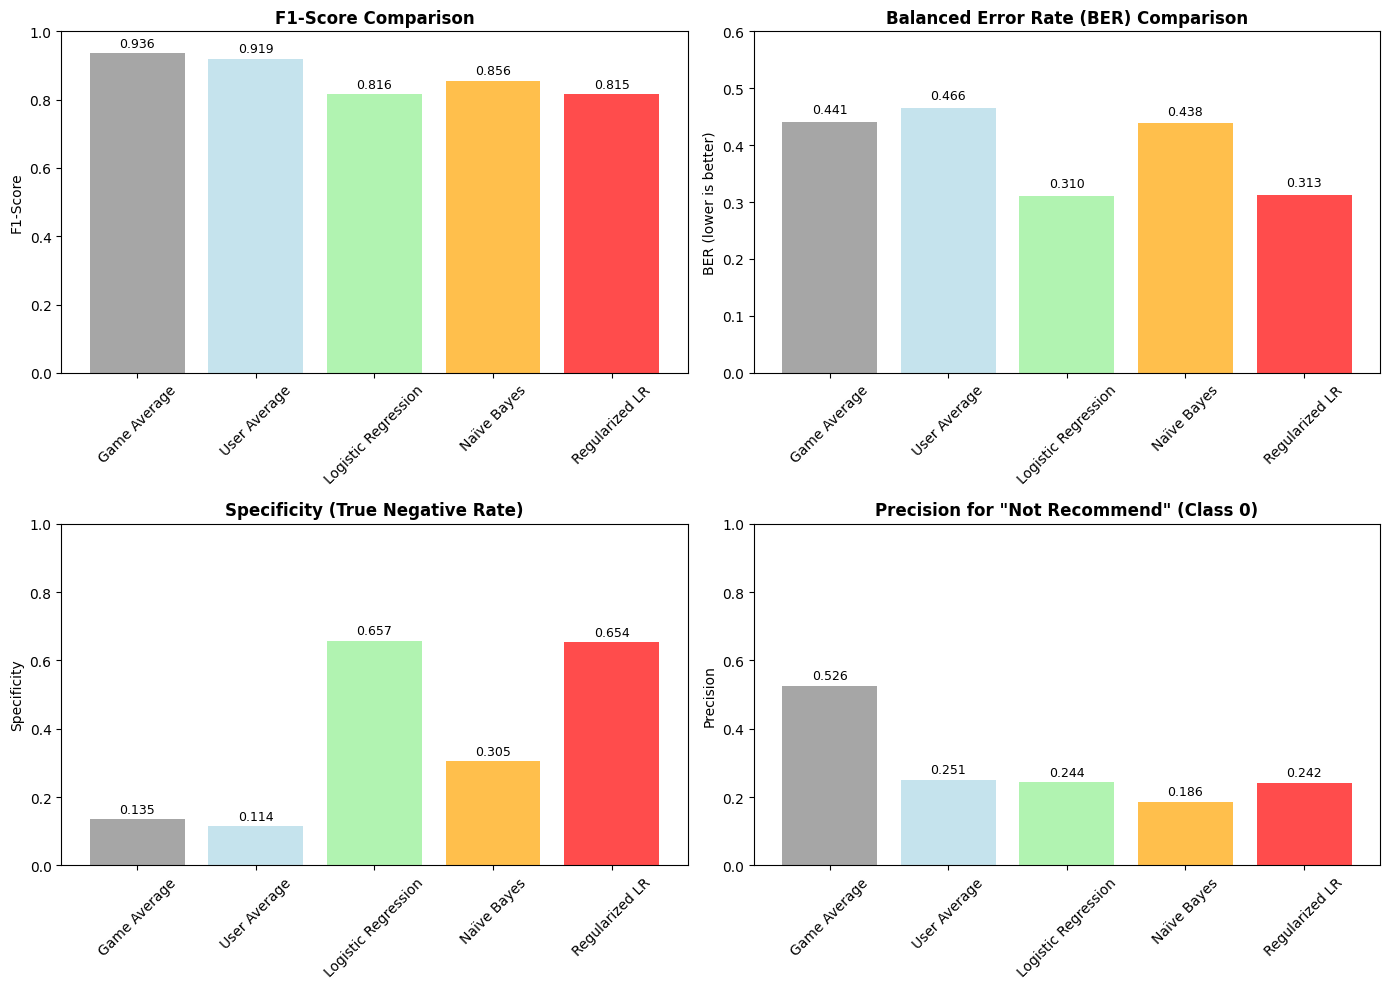


Model comparison plots saved as 'model_comparison.png'


In [ ]:
print("\n" + "="*60)
print("COMPARISON OF ALL METHODS (Test Set)")
print("="*60)

# Create comparison DataFrame
comparison_df = pd.DataFrame(test_results).T
print("\nPerformance metrics for all methods (sorted by F1-Score):")
sorted_df = comparison_df[['accuracy', 'f1', 'ber', 'specificity', 'precision_0']].round(4).sort_values('f1', ascending=False)
print(sorted_df)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. F1-Score comparison
methods = list(test_results.keys())
f1_scores = [test_results[m]['f1'] for m in methods]

colors = ['gray', 'lightblue', 'lightgreen', 'orange', 'red', 'purple']
bars1 = axes[0, 0].bar(methods, f1_scores, color=colors[:len(methods)], alpha=0.7)
axes[0, 0].set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('F1-Score', fontsize=10)
axes[0, 0].set_ylim(0, 1.0)
axes[0, 0].tick_params(axis='x', rotation=45)
for bar, score in zip(bars1, f1_scores):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# 2. BER comparison
ber_scores = [test_results[m]['ber'] for m in methods]
bars2 = axes[0, 1].bar(methods, ber_scores, color=colors[:len(methods)], alpha=0.7)
axes[0, 1].set_title('Balanced Error Rate (BER) Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('BER (lower is better)', fontsize=10)
axes[0, 1].set_ylim(0, 0.6)
axes[0, 1].tick_params(axis='x', rotation=45)
for bar, score in zip(bars2, ber_scores):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Specificity (True Negative Rate) comparison
specificity_scores = [test_results[m]['specificity'] for m in methods]
bars3 = axes[1, 0].bar(methods, specificity_scores, color=colors[:len(methods)], alpha=0.7)
axes[1, 0].set_title('Specificity (True Negative Rate)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Specificity', fontsize=10)
axes[1, 0].set_ylim(0, 1.0)
axes[1, 0].tick_params(axis='x', rotation=45)
for bar, score in zip(bars3, specificity_scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# 4. Precision for class 0 comparison
precision_0_scores = [test_results[m]['precision_0'] for m in methods]
bars4 = axes[1, 1].bar(methods, precision_0_scores, color=colors[:len(methods)], alpha=0.7)
axes[1, 1].set_title('Precision for "Not Recommend" (Class 0)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Precision', fontsize=10)
axes[1, 1].set_ylim(0, 1.0)
axes[1, 1].tick_params(axis='x', rotation=45)
for bar, score in zip(bars4, precision_0_scores):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{score:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nModel comparison plots saved as 'model_comparison.png'")

## 4.3 Feature Importance Analysis


FEATURE IMPORTANCE ANALYSIS

Top 15 most important features for Logistic Regression:

Positive coefficients (associated with recommend=1):
  sentiment_Overwhelmingly Positive: 2.1310
  sentiment_Very Positive: 0.8223
  sentiment_Unknown: 0.4062
  genre_free_to_play: 0.3209
  genre_video_production: 0.1511
  price_log: 0.1480
  genre_animation_&amp;_modeling: 0.1381
  genre_utilities: 0.1180

Negative coefficients (associated with recommend=0):
  sentiment_Mostly Negative: -2.3685
  sentiment_Mixed: -0.6435
  sentiment_Overwhelmingly Negative: -0.5421
  genre_massively_multiplayer: -0.3900
  genre_sports: -0.2377
  review_length_log: -0.1506
  sentiment_Very Negative: -0.1276
  genre_action: -0.0899


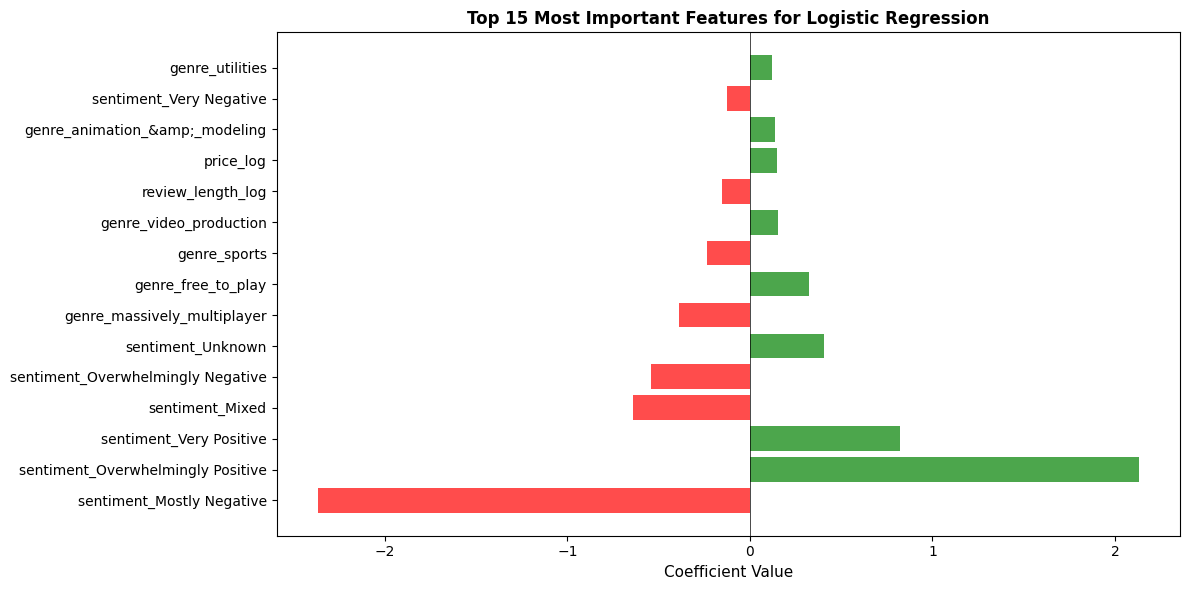


Feature importance plot saved as 'feature_importance.png'


In [ ]:
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

print("\nTop 15 most important features for Logistic Regression:")
feature_names = X.columns.tolist()
coefs = model_lr.coef_[0]

# Get feature importance (absolute value of coefficients)
feature_importance = list(zip(feature_names, coefs))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

print("\nPositive coefficients (associated with recommend=1):")
pos_features = [(f, c) for f, c in feature_importance if c > 0][:8]
for feature, coef in pos_features:
    print(f"  {feature}: {coef:.4f}")

print("\nNegative coefficients (associated with recommend=0):")
neg_features = [(f, c) for f, c in feature_importance if c < 0][:8]
for feature, coef in neg_features:
    print(f"  {feature}: {coef:.4f}")

# Plot top features
top_n = 15
top_features = feature_importance[:top_n]
features, importance = zip(*top_features)

plt.figure(figsize=(12, 6))
colors = ['green' if imp > 0 else 'red' for imp in importance]
plt.barh(range(len(features)), importance, color=colors, alpha=0.7)
plt.yticks(range(len(features)), features, fontsize=10)
plt.xlabel('Coefficient Value', fontsize=11)
plt.title(f'Top {top_n} Most Important Features for Logistic Regression', fontsize=12, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFeature importance plot saved as 'feature_importance.png'")

## 4.4 Model Validity Across Groups

In [ ]:
# 4.4 Model Validity Across Groups
print("\n" + "="*60)
print("MODEL VALIDITY ACROSS GROUPS")
print("="*60)

# Check performance on different subsets
print("\n1. Performance on Popular vs Unpopular Games:")

# Define popular games (top 20% by review count in training)
game_review_counts = train_df['item_id'].value_counts()
popular_threshold = np.percentile(game_review_counts.values, 80)
popular_games = game_review_counts[game_review_counts >= popular_threshold].index
unpopular_games = game_review_counts[game_review_counts < popular_threshold].index

# Filter test set
popular_mask = test_df['item_id'].isin(popular_games)
unpopular_mask = test_df['item_id'].isin(unpopular_games)

if popular_mask.any():
    popular_indices = test_df[popular_mask].index.intersection(X_test.index)
    if len(popular_indices) > 0:
        y_pred_popular = best_model.predict(X_test.loc[popular_indices])
        acc_popular = accuracy_score(y_test.loc[popular_indices], y_pred_popular)
        f1_popular = f1_score(y_test.loc[popular_indices], y_pred_popular, zero_division=0)
        ber_popular = 0.5 * (
            np.sum((y_pred_popular == 1) & (y_test.loc[popular_indices] == 0)) / 
            (np.sum((y_pred_popular == 1) & (y_test.loc[popular_indices] == 0)) + 
             np.sum((y_pred_popular == 0) & (y_test.loc[popular_indices] == 0)) + 1e-10) +
            np.sum((y_pred_popular == 0) & (y_test.loc[popular_indices] == 1)) / 
            (np.sum((y_pred_popular == 0) & (y_test.loc[popular_indices] == 1)) + 
             np.sum((y_pred_popular == 1) & (y_test.loc[popular_indices] == 1)) + 1e-10)
        )
        print(f"  Popular games (≥{popular_threshold:.0f} reviews): {len(popular_indices):,} samples")
        print(f"    Accuracy: {acc_popular:.4f}, F1: {f1_popular:.4f}, BER: {ber_popular:.4f}")

if unpopular_mask.any():
    unpopular_indices = test_df[unpopular_mask].index.intersection(X_test.index)
    if len(unpopular_indices) > 0:
        y_pred_unpopular = best_model.predict(X_test.loc[unpopular_indices])
        acc_unpopular = accuracy_score(y_test.loc[unpopular_indices], y_pred_unpopular)
        f1_unpopular = f1_score(y_test.loc[unpopular_indices], y_pred_unpopular, zero_division=0)
        ber_unpopular = 0.5 * (
            np.sum((y_pred_unpopular == 1) & (y_test.loc[unpopular_indices] == 0)) / 
            (np.sum((y_pred_unpopular == 1) & (y_test.loc[unpopular_indices] == 0)) + 
             np.sum((y_pred_unpopular == 0) & (y_test.loc[unpopular_indices] == 0)) + 1e-10) +
            np.sum((y_pred_unpopular == 0) & (y_test.loc[unpopular_indices] == 1)) / 
            (np.sum((y_pred_unpopular == 0) & (y_test.loc[unpopular_indices] == 1)) + 
             np.sum((y_pred_unpopular == 1) & (y_test.loc[unpopular_indices] == 1)) + 1e-10)
        )
        print(f"  Unpopular games (<{popular_threshold:.0f} reviews): {len(unpopular_indices):,} samples")
        print(f"    Accuracy: {acc_unpopular:.4f}, F1: {f1_unpopular:.4f}, BER: {ber_unpopular:.4f}")

print("\n2. Performance on Active vs Inactive Users:")
# Define active users (top 30% by playtime)
active_threshold = np.percentile(train_df['user_playtime_hours'].fillna(0), 70)
active_mask = test_df['user_playtime_hours'] >= active_threshold
inactive_mask = test_df['user_playtime_hours'] < active_threshold

if active_mask.any():
    active_indices = test_df[active_mask].index.intersection(X_test.index)
    if len(active_indices) > 0:
        y_pred_active = best_model.predict(X_test.loc[active_indices])
        acc_active = accuracy_score(y_test.loc[active_indices], y_pred_active)
        f1_active = f1_score(y_test.loc[active_indices], y_pred_active, zero_division=0)
        ber_active = 0.5 * (
            np.sum((y_pred_active == 1) & (y_test.loc[active_indices] == 0)) / 
            (np.sum((y_pred_active == 1) & (y_test.loc[active_indices] == 0)) + 
             np.sum((y_pred_active == 0) & (y_test.loc[active_indices] == 0)) + 1e-10) +
            np.sum((y_pred_active == 0) & (y_test.loc[active_indices] == 1)) / 
            (np.sum((y_pred_active == 0) & (y_test.loc[active_indices] == 1)) + 
             np.sum((y_pred_active == 1) & (y_test.loc[active_indices] == 1)) + 1e-10)
        )
        print(f"  Active users (≥{active_threshold:.1f} hours): {len(active_indices):,} samples")
        print(f"    Accuracy: {acc_active:.4f}, F1: {f1_active:.4f}, BER: {ber_active:.4f}")

if inactive_mask.any():
    inactive_indices = test_df[inactive_mask].index.intersection(X_test.index)
    if len(inactive_indices) > 0:
        y_pred_inactive = best_model.predict(X_test.loc[inactive_indices])
        acc_inactive = accuracy_score(y_test.loc[inactive_indices], y_pred_inactive)
        f1_inactive = f1_score(y_test.loc[inactive_indices], y_pred_inactive, zero_division=0)
        ber_inactive = 0.5 * (
            np.sum((y_pred_inactive == 1) & (y_test.loc[inactive_indices] == 0)) / 
            (np.sum((y_pred_inactive == 1) & (y_test.loc[inactive_indices] == 0)) + 
             np.sum((y_pred_inactive == 0) & (y_test.loc[inactive_indices] == 0)) + 1e-10) +
            np.sum((y_pred_inactive == 0) & (y_test.loc[inactive_indices] == 1)) / 
            (np.sum((y_pred_inactive == 0) & (y_test.loc[inactive_indices] == 1)) + 
             np.sum((y_pred_inactive == 1) & (y_test.loc[inactive_indices] == 1)) + 1e-10)
        )
        print(f"  Inactive users (<{active_threshold:.1f} hours): {len(inactive_indices):,} samples")
        print(f"    Accuracy: {acc_inactive:.4f}, F1: {f1_inactive:.4f}, BER: {ber_inactive:.4f}")

print("\n3. Performance on Different Price Ranges:")
price_ranges = [
    (0, 0, "Free"),
    (0.01, 10, "$0-$10"),
    (10.01, 20, "$10-$20"),
    (20.01, 1000, "$20+")
]

for min_price, max_price, label in price_ranges:
    if max_price == 0:
        price_mask = test_df['price'] == 0
    else:
        price_mask = (test_df['price'] >= min_price) & (test_df['price'] <= max_price)
    
    if price_mask.any():
        price_indices = test_df[price_mask].index.intersection(X_test.index)
        if len(price_indices) > 0:
            y_pred_price = best_model.predict(X_test.loc[price_indices])
            acc_price = accuracy_score(y_test.loc[price_indices], y_pred_price)
            f1_price = f1_score(y_test.loc[price_indices], y_pred_price, zero_division=0)
            ber_price = 0.5 * (
                np.sum((y_pred_price == 1) & (y_test.loc[price_indices] == 0)) / 
                (np.sum((y_pred_price == 1) & (y_test.loc[price_indices] == 0)) + 
                 np.sum((y_pred_price == 0) & (y_test.loc[price_indices] == 0)) + 1e-10) +
                np.sum((y_pred_price == 0) & (y_test.loc[price_indices] == 1)) / 
                (np.sum((y_pred_price == 0) & (y_test.loc[price_indices] == 1)) + 
                 np.sum((y_pred_price == 1) & (y_test.loc[price_indices] == 1)) + 1e-10)
            )
            print(f"  {label}: {len(price_indices):,} samples")
            print(f"    Accuracy: {acc_price:.4f}, F1: {f1_price:.4f}, BER: {ber_price:.4f}")


MODEL VALIDITY ACROSS GROUPS

1. Performance on Popular vs Unpopular Games:
  Popular games (≥14 reviews): 279 samples
    Accuracy: 0.6308, F1: 0.7664, BER: 0.5413
  Unpopular games (<14 reviews): 75 samples
    Accuracy: 0.5733, F1: 0.7091, BER: 0.5238

2. Performance on Active vs Inactive Users:
  Active users (≥2475.3 hours): 132 samples
    Accuracy: 0.5985, F1: 0.7363, BER: 0.5365
  Inactive users (<2475.3 hours): 189 samples
    Accuracy: 0.6138, F1: 0.7559, BER: 0.5907

3. Performance on Different Price Ranges:
  Free: 91 samples
    Accuracy: 0.6044, F1: 0.7429, BER: 0.5386
  $0-$10: 72 samples
    Accuracy: 0.5556, F1: 0.7037, BER: 0.5455
  $10-$20: 95 samples
    Accuracy: 0.6632, F1: 0.7922, BER: 0.5244
  $20+: 57 samples
    Accuracy: 0.6140, F1: 0.7556, BER: 0.5903


# 5. Related Work

## 5.1 Similar Reccoendation Datasets

 Steam has been used as a benchmark for recommender systems due to how it provides a great benchmark for implicit and explicit feedback such as purchases, playtime, and recommend labels. Pathak collected a large Steam dataset which we directly used that contains user game purchases from the AUS community in order to study how to recommend game bundles rather than just single games.

 More recent work (2024) done by Blue builds a dataset using the Steam Web API and recommendation APIto obtain user's personal game libraries, playtime, reviews, and scraped tags. This was then used to analyse how Steam recommendation engine favors large studies  over indie devs and to build their actual own recommendation models.

 McAuley and Wan has worked with similar user item interaction datasets from large platforms to study more general recommendations problems such a multi stage feedback.

 In our work particulary, we use Pathak datasets to combine user item interactions with item metadata. However, our goal focuses more on the recommendation label as the target, and we use simple metadata features to support models. 

## 5.2 Prior Work


**Modeling Multiple Feedback types**

Wan and McAuley modeled users actions in a chain, from simple action such as clicks to strong actions (actually clicking recommend). Using all feedback helped improve prediction of rare actions like recommend

**Using Steam content features**

Blue used Steam tags, genres, and playtime to help predict what games users might like. THeir findings include that combining interaction data with content featurs works better than content alone.

**Bundle Recommendation**

Pathak used Steam data to recommend bundles of games. They learned at the end user and game patterns using Bayesian Personalized ranking (BPR) and then after combined those scores to decide which bundle a user might want.

## 5.3 Comparison to Our Results

Past research shows the same simplistic pattern:
- models that use user item interactions perform better
- models that use only content features perform worse


Our goal is different:
1. Different task: We predict binary "recommend/not recomend" label, not next item prediction 
2. Simpler models: We do not use sequence models or latent factor models, our models consist of basic features and straightforward prediction  

Our results  didn't reach same performance reportd in prior work partly because of the datasets we used being highly imbalanced. With around 88% of reiviews being positive recommendations. This makes our simple baselines perform suprsingly well. Since our 3 model that we tested only use basic metadata and limited user history. They struggle to outperform the baseline models. In contrast, prior work uses richer signals such as playtime and multistage feedback which provides more info and allow for like strong models such as BPR or sequential networks to achieve higher benchmark performances.


# References

> **Self-attentive sequential recommendation**
> *Wang-Cheng Kang, Julian McAuley*
> ICDM, 2018
> [pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/icdm18.pdf)

> **Item recommendation on monotonic behavior chains**
> *Mengting Wan, Julian McAuley*
> RecSys, 2018
> [pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/recsys18b.pdf)

> **Generating and personalizing bundle recommendations on Steam**
> *Apurva Pathak, Kshitiz Gupta, Julian McAuley*
> SIGIR, 2017
> [pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir17.pdf)

> Tirumala, Anudeep, et al. “A Survey of Steam Game Recommendation Systems.” 
> *SMU Data Science Review*, 2019. [pdf](https://scholar.smu.edu/datasciencereview/vol2/iss1/7/)
